In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

Read Dataset

In [2]:
df = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [3]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

In [4]:
df.shape

(4845, 2)

In [5]:
df

,sentiment,Message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


In [6]:
df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

In [7]:
df

,sentiment,Message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


VISUALIZING THE DATA

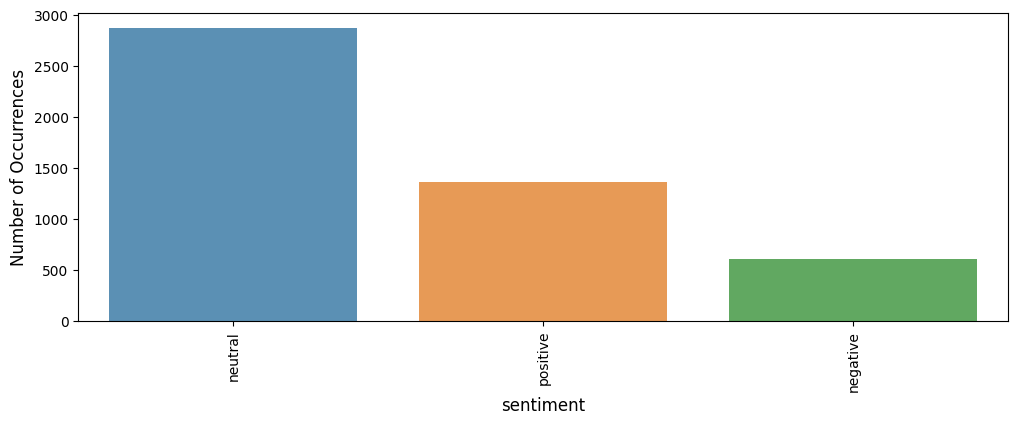

In [8]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12, 4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [9]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [10]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .
Message: 0


In [11]:
print_message(0)

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
Message: 1


Text Preprocessing Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [12]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [13]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4845 unique tokens.


In [14]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [15]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', '``', 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

Model DM = 1

This work use DM=1 (it preserve word order)

In [16]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


100%|█████████████████████████████████████████████████████████████████████████| 4844/4844 [00:00<00:00, 1612220.96it/s]


In [17]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|█████████████████████████████████████████████████████████████████████████| 4844/4844 [00:00<00:00, 2521684.07it/s]


CPU times: total: 3 s
Wall time: 9.29 s


In [18]:
print(d2v_model)

Doc2Vec<dm/m,d100,n5,w8,s0.001>


In [19]:
len(d2v_model.wv.index_to_key)

11682

In [20]:
# save the vectors in a new matrix
embedding_dim = 100  # Change this to match the dimensionality of your Doc2Vec model
num_docs = len(d2v_model.dv)
embedding_matrix = np.zeros((num_docs, embedding_dim))

# Fill the embedding matrix
for i in range(num_docs):
    embedding_matrix[i] = d2v_model.dv[i]

# Measuring distance between two vectors (related to cosine similarity)

In [21]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.7105900049209595),
 ('profits', 0.5389329195022583),
 ('103.4', 0.5287207961082458),
 ('chopra', 0.518142819404602),
 ('atul', 0.4901237487792969),
 ('turnover', 0.4683420658111572),
 ('trojan', 0.4567994177341461),
 ('mistake', 0.45057162642478943),
 ('income', 0.44376739859580994),
 ('pcmag.com', 0.4353073239326477)]

In [22]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('property', 0.550059974193573),
 ('municipality', 0.47347429394721985),
 ('fund', 0.4535560607910156),
 ('matka-vekka', 0.44793301820755005),
 ('luembourg-registered', 0.42485982179641724),
 ('ebit', 0.4232809543609619),
 ('reserved', 0.42003336548805237),
 ('baker', 0.4166097640991211),
 ('properties', 0.41281136870384216),
 ('equity', 0.4127344787120819)]

In [23]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.956885814666748),
 ('aptly', 0.7957460284233093),
 ('aboavista', 0.7694252729415894),
 ('remarked', 0.7333269715309143),
 ('frank', 0.7044240236282349),
 ('nau', 0.6997327208518982),
 ('computer-related', 0.6971443891525269),
 ('apac', 0.6873880624771118),
 ('buys', 0.6815649271011353),
 ('umbrellas', 0.6747748255729675)]

Plot Similarity word in Doc2vec

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates a t-SNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index.keys():  # Iterate through word keys in the model's vocabulary
        tokens.append(model.wv[word])  # Access the word vectors using model.wv
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    tokens_np = np.array(tokens)  # Convert 'tokens' to a NumPy array
    new_values = tsne_model.fit_transform(tokens_np)  # Pass the NumPy array as input

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


# Create the LSTM Model

The parameter used here inspired by [3].



In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import numpy as np  # You should import numpy

# Initialize a Sequential model
model = Sequential()
embedding_matrix = np.random.rand(4845, 128)

model.add(Embedding(input_dim=4845, output_dim=128, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# Define a function to split the input data
def split_input(sequence):
     return sequence[:, :-1], sequence[:, 1:]

# Add an LSTM layer
model.add(LSTM(50, return_sequences=False))

# Add a Dense layer with softmax activation for classification
model.add(Dense(3, activation="softmax"))

# Output model summary
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           620160    
                                                                 
 lstm (LSTM)                 (None, 50)                35800     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 656113 (2.50 MB)
Trainable params: 656113 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [30]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/embedding_2/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ritesh\AppData\Local\Temp\ipykernel_19012\1271005725.py", line 2, in <module>
      history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_2/embedding_2/embedding_lookup'
indices[15,25] = 6268 is not in [0, 4845)
	 [[{{node sequential_2/embedding_2/embedding_lookup}}]] [Op:__inference_train_function_3446]

In [ ]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [31]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/embedding_2/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ritesh\AppData\Local\Temp\ipykernel_19012\3777238185.py", line 2, in <module>
      _, train_acc = model.evaluate(X_train, Y_train, verbose=2)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1850, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_2/embedding_2/embedding_lookup'
indices[23,46] = 8509 is not in [0, 4845)
	 [[{{node sequential_2/embedding_2/embedding_lookup}}]] [Op:__inference_test_function_4054]

In [32]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/embedding_2/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ritesh\AppData\Local\Temp\ipykernel_19012\485327472.py", line 2, in <module>
      yhat_probs = model.predict(X_test, verbose=0)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_2/embedding_2/embedding_lookup'
indices[26,48] = 8811 is not in [0, 4845)
	 [[{{node sequential_2/embedding_2/embedding_lookup}}]] [Op:__inference_predict_function_4564]

In [33]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

In [ ]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [34]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/embedding_2/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ritesh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ritesh\AppData\Local\Temp\ipykernel_19012\3777238185.py", line 2, in <module>
      _, train_acc = model.evaluate(X_train, Y_train, verbose=2)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1850, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ritesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_2/embedding_2/embedding_lookup'
indices[26,48] = 8811 is not in [0, 4845)
	 [[{{node sequential_2/embedding_2/embedding_lookup}}]] [Op:__inference_test_function_4054]

**Save Model**


In [ ]:
model.save('Mymodel.h5')

**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

In [ ]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])